# Project - Day 4 - MLFlow training of your model

## Insert MLFlow parameters
The following cell is marked as `parameters`, you might find useful to include MLFlow usable parameters here for varying and experimenting different values for the CNN.

In [26]:
activation = 'relu'
reg = 1e-2

## Excercise

Based on the Training step of the project done on day 3:

- train a model and store the metrics of the training process in MLFlow. e.g.:
```python
with mlflow.start_run(tags={"mlflow.runName": "train"}) as mlrun:

    losses = []
    val_losses = []
    !pip install -q tqdm
    from tqdm import trange
    
    n_epochs = 5
    n_blocks = y_train.numblocks[0]
    
    for epoch in trange(n_epochs):
        for X, y in zip(X_train.blocks, y_train.blocks):
            losses.append(
                (len(losses)/n_blocks, classifier.train_on_batch(X.compute(), y.compute()))
            )
        ls = classifier.test_on_batch(X_valid, y_valid)
        val_losses.append(
            (len(losses)/n_blocks,ls)
            )
        mlflow.log_metric("loss", ls, step=int(len(losses)/n_blocks))

```

- store the model in MLFlow of the usage on the next step of the pipeline, e.g.:

```python
    classifier.save("classifier.keras")
    mlflow.log_artifact("classifier.keras")
    prds = classifier.predict(X_valid.compute())
    signature = infer_signature(X_valid.compute(), prds)
    mlflow.tensorflow.log_model(classifier, "model", registered_model_name="CYGNO_CNN", signature=signature)
```

- store any additional plot that you find useful to track as a MLFlow artifact

In [17]:
## We will be using Numpy, Pyplot and Tensorflow as our scientific tool box
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

## BytesIO for defining in-memory file-like objects
from io import BytesIO

## Dask and in particular dask array for defining OOM pipelines
import dask
import dask.array as da

## Progress bars
from tqdm import tqdm

import mlflow

In [18]:
from glob import glob
filenames = glob("/home/jovyan/data/data/export/*/*/*/*.png")
print (f"Found {len(filenames)} filenames")

Found 612 filenames


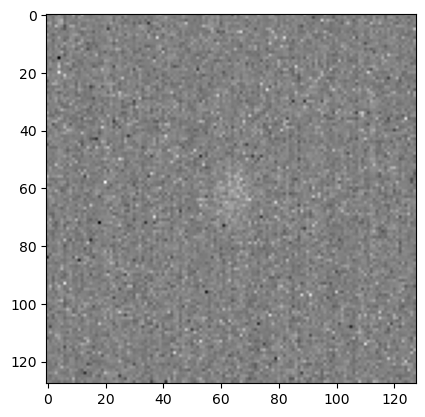

In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import dask, dask.array

## See Day 2
@dask.delayed 
def load_image(filename: str):
    """Wrapper function loading image as a dask.delayed"""
    return np.asarray(Image.open(filename))

## See Day 2
def load_raw_images(filenames):
    """Load the images from the file paths in `filenames` into a delayed dask-array"""
    return dask.array.stack([
        dask.array.from_delayed(load_image(f), shape=(576, 576), dtype=np.uint8) 
        for f in filenames
    ], axis=0)


## Discussed in Day 1, implemented in Day 2
def windowing(dask_image, x_min, x_max):
    """Maps the pixel values from the interval [x_min, x_max] to [0, 1]"""
    return dask.array.clip((dask_image - x_min)/(x_max - x_min), 0., 1.)

## Discussed in Day 1, implemented in Day 2
def crop_center(dask_image, half_win=64):
    """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
    low, high = 576//2 - half_win, 576//2 + half_win
    return dask_image[:,low:high, low:high]

preprocessed = crop_center(windowing(load_raw_images(filenames), 60, 130))
plt.imshow(preprocessed[0].compute(), cmap='gray')
plt.show()

In [20]:
import re
def energy_keV_from_path(filenames):
    """
    Return a dask array with the energy (in keV) as obtained parsing a sequence of filenames passed 
    as an argument.
    """
    return dask.array.from_array([float(re.findall(r"/([0-9]+)_keV", f)[0]) for f in filenames])

def is_nuclear_from_path(filenames):
    """
    Return an array of boolean, true for nuclear recoil, or false for electron recoils as 
    obtained parsing the list of filenames passed as an argument.
    """
    return dask.array.from_array([float('NR' in re.findall(r"/([NE]R)/", f)) for f in filenames])

In [21]:
import numpy as np

shuffled_filenames = np.random.permutation(np.array(filenames))


In [22]:
## Plotting 
import matplotlib.pyplot as plt

## Tensorflow for machine learning
import tensorflow as tf

## Dask for out-of-memory pipelines
import dask.array as da

## Progress bar
from tqdm import trange 

n_validation = 50

validation_files = shuffled_filenames[:n_validation]
training_files = shuffled_filenames[n_validation:]

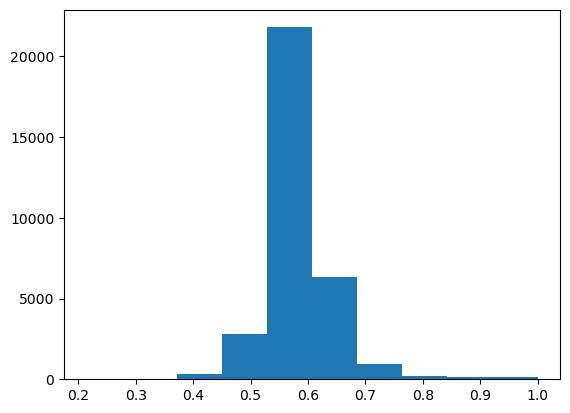

In [23]:
training_set = crop_center(windowing(load_raw_images(training_files), 60, 130))
validation_set = crop_center(windowing(load_raw_images(validation_files), 60, 130))

plt.hist(training_set[:2].flatten().compute())

training_label = is_nuclear_from_path(training_files)
validation_label = is_nuclear_from_path(validation_files)

training_energy = energy_keV_from_path(training_files)
validation_energy = energy_keV_from_path(validation_files)

In [27]:
## The learning rate defines the leap taken at each update of the weights
learning_rate = 5e-4

## We create a deep sequential model (layers are executed in a sequence, one after the other)
classifier = tf.keras.models.Sequential([
    ## We reshape the images making it explicit that they have 1 single channel
    tf.keras.layers.Reshape((128, 128, 1), name="reshape"),

    ## First Convolutional block (conv + conv + max pooling)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation=activation, kernel_regularizer=tf.keras.regularizers.L2(reg), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation=activation, kernel_regularizer=tf.keras.regularizers.L2(reg), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    ## Second Convolutional block (equal to the previous one)
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation=activation, kernel_regularizer=tf.keras.regularizers.L2(reg), kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation=activation, kernel_regularizer=tf.keras.regularizers.L2(reg), kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    ## Finally, we flatten the generated image and we use the computed channels as input of a 
    ## last dense layer, activated by a sigmoid.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
])

## Before training we may want to specify the input shape of the dataset:
## Batches of any number of elements (None) with each element being a 28x28 matrix
classifier.build(input_shape=(None, 128, 128))

## Then we must assign a loss function and an optimizer to be used 
## for the training.
classifier.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate)
)

## Optionally, we can print the model obtained, counting the variables and estimating the 
## storage requirements if we plan to export the model.
display(classifier.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 8)         584       
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 8)         584       
                                                        

2023-10-26 15:20:02.328907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None

In [28]:
batch_size = 10

X_train = da.rechunk(training_set, chunks=(batch_size, 128, 128))
X_valid = da.rechunk(validation_set, chunks=(batch_size, 128, 128))
y_train = da.rechunk(training_label, chunks=(batch_size,))
y_valid = da.rechunk(validation_label, chunks=(batch_size,))


print(y_valid)
print(X_valid)

dask.array<rechunk-merge, shape=(50,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
dask.array<rechunk-merge, shape=(50, 128, 128), dtype=float64, chunksize=(10, 128, 128), chunktype=numpy.ndarray>


In [ ]:
with mlflow.start_run(tags={"mlflow.runName": "train"}) as mlrun:

    losses = []
    validation_losses = []
    n_epochs = 20  ## <-- 🆕 We define the number of epochs
    n_blocks = X_train.numblocks[0]

    with trange(n_epochs*n_blocks, unit='updates') as progress_bar:
        for epoch in range(n_epochs):  ## <-- 🆕 We introduce a simple loop on the number of epochs
            for image_chunk, label_chunk in zip(X_train.blocks, y_train.blocks):
                progress_bar.update(1)
                loss = classifier.train_on_batch(image_chunk, label_chunk)
                losses.append(loss)
        
                validation_loss = classifier.test_on_batch(X_valid, y_valid)
                validation_losses.append(validation_loss)
                
                mlflow.log_metric("loss", ls, step=int(len(losses)/n_blocks))

    classifier.save("classifier.keras")
    mlflow.log_artifact("classifier.keras")
    prds = classifier.predict(X_valid.compute())
    signature = infer_signature(X_valid.compute(), prds)
    mlflow.tensorflow.log_model(classifier, "model", registered_model_name="CYGNO_CNN", signature=signature)
    

    '''
    losses = []
    val_losses = []
    !pip install -q tqdm
    from tqdm import trange
   
    #inserire codice giorno 3
    
    n_epochs = 5
    n_blocks = y_train.numblocks[0]
    
    for epoch in trange(n_epochs):
        for X, y in zip(X_train.blocks, y_train.blocks):
            losses.append(
                (len(losses)/n_blocks, classifier.train_on_batch(X.compute(), y.compute()))
            )
        ls = classifier.test_on_batch(X_valid, y_valid)
        val_losses.append(
            (len(losses)/n_blocks,ls)
            )
        mlflow.log_metric("loss", ls, step=int(len(losses)/n_blocks))
    '''

  0%|          | 0/5 [00:00<?, ?it/s]